# Is Germany Linear?

The question is not so easy to answer. The CSSE dataset looks as if the data is not linear and still exponentially growing. The RKI dataset tells a comletely different story. Still the sums are not so far apart. What is the difference?

 - CSSE: https://coronavirus.jhu.edu/map.html
 - RKI: https://experience.arcgis.com/experience/478220a4c454480e823b17327b2bf1d4

## Understanding the difference between CSSE/Jhons Hopkins University and Robert Koch Institute 


It is stated in the RKI dataset that some date gets reported late by idividual states in Germany. And usually there is even a multi day backlog. 
Though this data is not reflected in the CSSE dataset, that seem to always use the last days increment to create their number. 

This sheet pulls both datasets and compares them.

### RKI

In [1]:
%matplotlib inline
import requests as rq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
rki = pd.read_pickle('rki.pickle')
dfs = []
for offset in range(len(rki), 500000, 2000):
    d1 = rq.get('https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_COVID19/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json&resultOffset={}'.format(offset))
    j = d1.json()
    df = pd.DataFrame(e['attributes'] for e in j['features'])
    if len(df) == 0:
        break
    dfs.append(df)
if dfs:
    rki = pd.concat([rki] + dfs)
    rki.to_pickle('rki.pickle')
    
rki.AnzahlFall.sum()
rki['Meldedatum'] = pd.to_datetime(rki.Meldedatum*1000000)
rki_cases = rki.groupby('Meldedatum')[['AnzahlFall']].sum().cumsum()
rki_cases = rki_cases.rename(columns={'AnzahlFall': 'rki_cases'})

### CSSE

In [3]:
csse = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
csse_germany = csse[csse['Country/Region'] == 'Germany']
csse_germany = csse_germany.drop(['Lat', 'Long', 'Province/State'], axis='columns').set_index('Country/Region')
csse_germany_cases = csse_germany.transpose()
csse_germany_cases.index = pd.to_datetime(csse_germany_cases.index)
csse_germany_cases = csse_germany_cases.rename(columns={'Germany': 'csse_cases'})

# Differences

In [4]:
cases = csse_germany_cases.join(rki_cases).diff()
cases = cases.loc['2020-03-01':]
cases['cases_diff'] = cases.rki_cases - cases.csse_cases

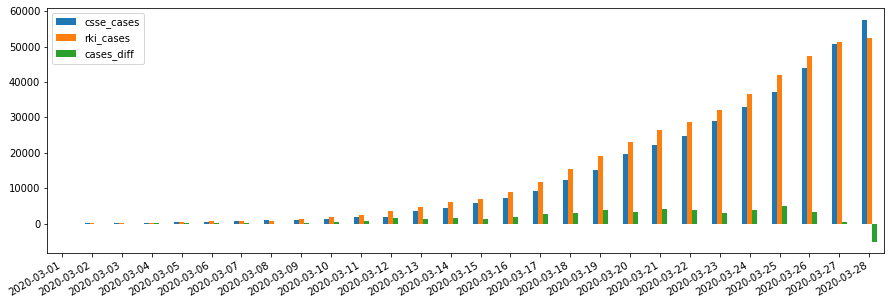

In [5]:
fig, ax = plt.subplots(figsize=(15,5))
to_plot = cases.copy()
to_plot.index = to_plot.index.date
to_plot.cumsum().plot(kind='bar', ax=ax)
fig.autofmt_xdate()

The difference in cases is somewhat constant in the past, only the last 2 days differ (consostently since I look at these graphs). If you look at the disclaimer of the rki webage this makes sense due to the 1 or 2 days delay in proper reporting of official figures. Still the csse dataset has more recent data which does not need to follow the official reporting lines.

What portion is really new?

Given that the reporting behavior for RKI does not change the numbers older than 3 days give relaistic relation between up to date csse numbers and the incomplete but historially more precise dataset of RKI. Let's use this. 

Let's conside the timeframe until now - 2 days. (becareful with the sum pandas considers an end date to be inclusive!!!)

In [6]:
pivot = cases.index[-3]
cases[:pivot].cases_diff.sum()

3394.0

So we have this number of cases that are repoted by CSSE as new, even though they are better explained historic. Compensate the increase by a decrease in the last 2 csse figures.

In [7]:
cases['rki_corrected_csse'] = cases.csse_cases
cases.loc[:pivot, 'rki_corrected_csse'] += cases.cases_diff
cases.loc[pivot + pd.to_timedelta(1, 'day'):, 'rki_corrected_csse'] -= cases[:pivot].cases_diff.sum() / 2

### Result

The red line is the start of measures in Bavaria, other countries followed shortly after that. My interpretation of this graph is that the measures are working and that Gemrany currently experiences linear growth. Hope this prevails and that it leads to possibilities to allow economy to reboot in a limited way! 

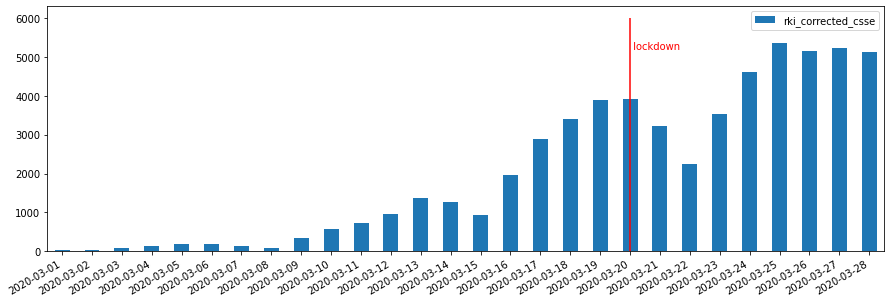

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
to_plot = cases.copy()
to_plot.index = to_plot.index.date
to_plot[['rki_corrected_csse']].plot(kind='bar', ax=ax)
plt.vlines([20 - 1], 0, 6000, color='red')
plt.annotate(' lockdown', (19, 5200), color='red')
fig.autofmt_xdate()